In [2]:
# All the imports

from __future__ import print_function, division
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import glob

from keras import backend as K
from keras.layers import Layer

import copy

import scipy.misc

from skimage.transform import resize

import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback, TensorBoard
from keras import backend as keras

from scipy.io import loadmat
from scipy.io import savemat

from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu

#import pylidc as pl
#from keras.backend.tensorflow_backend import set_session
import tensorflow as tf

import pywt
import numpy as np
#import pydicom
import matplotlib.pyplot as plt
import SimpleITK as sitk
import skimage.io as io
#from sklearn.decomposition import PCA
import collections, numpy
import warnings
from scipy import ndimage, misc
warnings.filterwarnings('ignore')

#import pymrt as mrt
#import pymrt.geometry
import ipyvolume as ipv
import copy




#from image_gen import ImageDataGenerator
#from load_data import loadDataMontgomery, loadDataJSRT
#from build_model import build_UNet2D_4L

import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint



import numpy
import warnings
from keras.layers import Convolution3D, Input, merge, RepeatVector, Activation
from keras.models import Model
from keras.layers.advanced_activations import PReLU
from keras import activations, initializers, regularizers
from keras.engine import Layer, InputSpec
from keras.utils.conv_utils import conv_output_length
#from keras.utils.np_utils import conv_output_length
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.engine.topology import Layer
import functools
import tensorflow as tf
import pickle
import time

In [5]:
# Helper Functions

def unet_vanilla(input_size = (960,64,1)):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 256
    
    inputs = Input(input_size)
    conv1 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 1))(conv2)
    conv3 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(4, 1))(drop4)

    conv5 = Conv2D(filter5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(filter5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(filter4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (4,1))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(filter3, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(filter2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,1))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9    = Conv2D(filter1, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    
    conv9  = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    #conv9  = PReLU()(conv9)
    
    conv9  = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9  = PReLU()(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'relu')(conv9)
    #conv10 = PReLU()(conv10)
    
    
    #conv9 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    #conv9 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(1, 1, activation = 'relu')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    return model

def unet_vanilla1(input_size = (800,64,1)):
    filter1 = 32
    filter2 = 64
    filter3 = 128
    filter4 = 256
    filter5 = 512
    
    inputs = Input(input_size)
    conv1 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 1))(conv2)
    conv3 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 1))(conv3)
    conv4 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 1))(drop4)

    conv5 = Conv2D(filter5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(filter5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.2)(conv5)

    up6 = Conv2D(filter4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,1))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(filter3, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,1))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(filter2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,1))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(filter1, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'relu')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'mean_absolute_error', metrics = ['mse'])
    return model

def unet_dense(input_size = (960,64,1)):
    filter1 = 16
    filter2 = 32
    filter3 = 64
    filter4 = 128
    filter5 = 256
    
    inputs = Input(input_size)
    
    a1  = MaxPooling2D(pool_size=(2, 2))(inputs)
    a2  = MaxPooling2D(pool_size=(2, 2))(a1)
    
    a3  = Flatten()(a2)
    b  = Dense(2400,   activation='relu', kernel_initializer = 'he_normal')(a3)
    b  = BatchNormalization()(b)
    
    e  = Dense(4800,   activation='relu', kernel_initializer = 'he_normal')(b)
    e  = BatchNormalization()(e)
    
    f  = Dense(4800,   activation='relu', kernel_initializer = 'he_normal')(e)
    f  = BatchNormalization()(f)
    
    g  = Dense(4800,   activation='relu', kernel_initializer = 'he_normal')(f)
    g  = BatchNormalization()(g)
    
    c  = Dense(2400,   activation='relu', kernel_initializer = 'he_normal')(g)
    d  = Reshape([200, 12, 1])(c)  # Downsampled Sinogram which will go in loss function
    
    up1 = Conv2D(filter5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (1, 1))(d))
    up1 = Concatenate()([up1, a2])
    
    up2 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(up1))
    up2 = Concatenate()([up2, a1])
    
    up3 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2, 2))(up2))
     
    out = Conv2D(1, 1, activation = 'relu')(up3)

    model = Model(input = inputs, output = [out, d])

    model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = ['mean_absolute_error', 'mean_absolute_error'],
                  loss_weights = [0.5, 0.5],
                  metrics = ['mse'])
    return model

#a = unet_dense()
#print(a.summary())

def unet_3d_prelu(input_size = (104, 56, 40, 1)):
    
    filter1 = 16
    filter2 = 32
    filter3 = 64
    filter4 = 128
    
    zfilter = 40
    
    inputs = Input(input_size)
    
    conv1 = Conv3D(filter1, (3, 3, zfilter), padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    
    conv1 = Conv3D(filter1, (3, 3, zfilter), padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = ReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2,2))(conv2)
    conv3 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = ReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    
    pool3 = MaxPooling3D(pool_size=(2, 2,2))(conv3)
    conv4 = Conv3D(filter3, 3,  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = ReLU()(conv4)
    conv4 = BatchNormalization()(conv4)

    up3    = UpSampling3D(size = (2,2,2))(conv4)
    merge3 = Add()([up3, conv3])
    merge3 = Conv3D(filter2, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge3)
    merge3 = ReLU()(merge3)
    merge3 = BatchNormalization()(merge3)    
    
    up2    = UpSampling3D(size = (2,2,2))(merge3)
    merge2 = Add()([up2, conv2])
    merge2 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge2)
    merge2 = ReLU()(merge2)
    merge2 = BatchNormalization()(merge2)    
    
    up1    = UpSampling3D(size = (2,2,2))(merge2)
    merge1 = Add()([up1, conv1])
    merge1 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    merge1 = ReLU()(merge1)
    merge1 = BatchNormalization()(merge1)    
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    up7 = ReLU()(up7)
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    up7 = ReLU()(up7)
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    up7 = ReLU()(up7)
    
    conv9 = Conv3D(1, 1, padding='same', kernel_initializer = 'he_normal')(up7)
    conv9 = ReLU()(conv9)
    
    model = Model(input = inputs, output = conv9)

    model.compile(optimizer = Adam(lr = 0.0001), loss = 'mean_absolute_error', 
                  metrics = ['mse'])
    
    return model

def unet_3d_prelu2(input_size = (104, 56, 40, 1)):
#def unet_3d_prelu2(input_size = (104, 24, 40, 1)):
    
    filter1 = 16
    filter2 = 32
    filter3 = 128
    
    zfilter = 3
    
    inputs = Input(input_size)
    
    conv1 = Conv3D(filter1, (3, 3, 3), padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Dropout(0.1)(conv1)
    conv1 = ReLU()(conv1)
    conv1 = BatchNormalization()(conv1)
    
    #conv1 = Conv3D(filter1, (3, 3, zfilter), padding = 'same', kernel_initializer = 'he_normal')(conv1)
    #conv1 = ReLU()(conv1)
    #conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPooling3D(pool_size=(2,2,2))(conv1)
    conv2 = Conv3D(filter2, (3, 3, 3),  padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Dropout(0.1)(conv2)
    conv2 = ReLU()(conv2)
    conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2,2))(conv2)
    conv3 = Conv3D(filter3, (3, 3, 10),  padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = ReLU()(conv3)
    conv3 = BatchNormalization()(conv3)
    
    pool3 = MaxPooling3D(pool_size=(2, 2,2))(conv3)
    conv4 = Conv3D(filter3, (3, 3, 5),  padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = ReLU()(conv4)
    conv4 = BatchNormalization()(conv4)

    up3    = UpSampling3D(size = (2,2,2))(conv4)
    merge3 = Concatenate()([up3, conv3])
    merge3 = Conv3D(filter2, (3, 3, 10),  padding = 'same', kernel_initializer = 'he_normal')(merge3)
    merge3 = Dropout(0.1)(merge3)
    merge3 = ReLU()(merge3)
    merge3 = BatchNormalization()(merge3)    
    
    up2    = UpSampling3D(size = (2,2,2))(merge3)
    merge2 = Concatenate()([up2, conv2])
    merge2 = Conv3D(filter1, 3,  padding = 'same', kernel_initializer = 'he_normal')(merge2)
    merge2 = Dropout(0.1)(merge2)
    merge2 = ReLU()(merge2)
    merge2 = BatchNormalization()(merge2)    
    
    up1    = UpSampling3D(size = (2,2,2))(merge2)
    merge1 = Concatenate()([up1, conv1])
    merge1 = Conv3D(filter1, (3, 3, 3),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
    merge1 = Dropout(0.1)(merge1)
    merge1 = ReLU()(merge1)
    #merge1 = BatchNormalization()(merge1)    
    
#     up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(merge1)
#     up7 = ReLU()(up7)
#     up7 = BatchNormalization()(up7)
    
#     up8 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(up7)
#     up8 = ReLU()(up8)
#     up8 = BatchNormalization()(up8)
    
#     up8 = Add()([up8, merge1])
    
#     up9 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(up8)
#     up9 = ReLU()(up9)
    
    conv9 = Conv3D(1, 1, padding='same', kernel_initializer = 'he_normal')(merge1)
    conv9 = ReLU()(conv9)
    
    model = Model(input = inputs, output = conv9)

    model.compile(optimizer = Adam(lr = 0.0005), loss = 'mean_absolute_error', 
                  metrics = ['mse'])
    return model

def unet_3d_prelu1(input_size = (104, 56, 40, 1)):
    filter1 = 16
    filter2 = 32
    filter3 = 64
    filter4 = 128
    zfilter = 40
    
    model = load_model('/media/dril/ubuntudata/DBT-NEW/models/model2.h5', compile=False)
    x     = model.layers[-3].output
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(x)
    up7 = ReLU()(up7)
    
    up7 = Conv3D(filter1, (3, 3, zfilter),  padding = 'same', kernel_initializer = 'he_normal')(up7)
    up7 = ReLU()(up7)
    
    conv9 = Conv3D(1, 1, padding='same', kernel_initializer = 'he_normal')(up7)
    conv9 = ReLU()(conv9)
    
    model1 = Model(input = model.input, output = conv9)
    model1.compile(optimizer = Adam(lr = 0.0001), loss = 'mse', metrics = ['mae'])
    
    model3 =  load_model('/media/dril/ubuntudata/DBT-NEW/models/model2.h5', compile=False)
    
    for i in range(len(model3.layers)-2):
        if len(model3.layers[i].get_weights()) > 0:
            model1.layers[i].set_weights(model3.layers[i].get_weights())
    
    return model1

def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax

# For checking if weights are same or not of two networks

# for i in range(40):
#     w1 = model3.layers[i].get_weights()
#     w2 = m2.layers[i].get_weights()
    
#     for j in range(len(w1)):
#         print(i, np.all(w1[j] == w2[j]))

In [ ]:
# For getting the shapes

allshapesx = []
allshapesy = []
allshapesz = []

for i in range(1, 177):
    a = loadmat('/media/dril/ubuntudata/attenuation_values/'+str(i)+'.mat')
    a = a['head']
    b = copy.deepcopy(a)
    a[a != 0 ] = 1
    rmin, rmax, cmin, cmax, zmin, zmax = bbox2_3D(a)
    b = b[rmin:rmax, cmin:cmax, zmin:zmax]
    
    allshapesx.append(b.shape[0])
    allshapesy.append(b.shape[1])
    allshapesz.append(b.shape[2])
    
    temp = int((800-b.shape[0])/2)
    vol = b
    vol = np.pad(b, ((temp, 800-temp-b.shape[0]), (320-b.shape[1], 0), (0, 448-b.shape[2])), 
                     'constant', constant_values=(0, 0))
    vol = np.moveaxis(vol, [1, 2], [2, 1]).astype(np.single)

    h = {}
    h['head'] = vol
    savemat('/media/dril/ubuntudata/attenuation_values_cropped/'+str(i)+'.mat', h,
            do_compression=True)
    print(i, vol.shape)

In [ ]:
# New size will be 800, 320, 448

In [ ]:
# For reading the data for training the 3D U-Net model

trainx = []
trainy = []
valx   = []
valy   = []

for i in range(1, 177):
    print(i)
    #volx = loadmat('/media/dril/ubuntudata/DBT-NEW/recons/sart_cir_zero_'+str(i)+'.mat')
    volx = loadmat('/media/dril/ubuntudata/DBT-NEW/recons-noise/fbp_'+str(i)+'_3_hann50.mat', verify_compressed_data_integrity=False)
    voly = loadmat('/media/dril/ubuntudata/DBT-NEW/attenuation_values_cropped/'+str(i)+'.mat')
    
    volx = volx['xfbp']
    voly = voly['head']
    
    voly = ndimage.zoom(voly, 0.125, order=1).astype(np.single)
    volx = ndimage.zoom(volx, 0.250, order=1).astype(np.single)
    
    if i <= 140:
        trainx.append(np.expand_dims(volx, axis=-1))
        trainy.append(np.expand_dims(voly, axis=-1))
    else:
        valx.append(np.expand_dims(volx,axis=-1))
        valy.append(np.expand_dims(voly,axis=-1))

trainx = np.array(trainx)
trainy = np.array(trainy)
valx   = np.array(valx)
valy   = np.array(valy)

trainx  = np.pad(trainx, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
trainy  = np.pad(trainy, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
valx    = np.pad(valx, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
valy    = np.pad(valy, ((0,0), (2, 2), (0, 0), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))

print(trainx.shape, trainy.shape)
print(valx.shape, valy.shape)

In [ ]:
# For reading the data for training the 2D U-Net model for sinogram completion

trainx = []
trainy = []
valx   = []
valy   = []

slices_train = 31523
slices_val   = 8133

trainx  = np.zeros((slices_train, 960, 64, 1), dtype=np.single)
trainy  = np.zeros((slices_train, 960, 64, 1), dtype=np.single)

valx   = np.zeros((slices_val, 960, 64, 1), dtype=np.single)  # This is from sart
valy   = np.zeros((slices_val, 960, 64, 1), dtype=np.single)


count_train = 0
count_val   = 0

for i in range(1, 177):
    x = loadmat('/media/dril/a19fa9b7-846c-45a0-be8c-ef93fea1e48c/gan-110-projections/g_noi_sart_'+str(i)+'.mat', verify_compressed_data_integrity=False)
    #x = loadmat('/media/dril/ubuntudata/DBT-NEW/gan-90-projections/projections/g_noi_sart_'+str(i)+'.mat', verify_compressed_data_integrity=False)
    x = x['g_noi_nonoise']
    
    y = loadmat('/media/dril/ubuntudata/DBT-NEW/gan-110-projections/g_noi_nonoise_'+str(i)+'.mat', verify_compressed_data_integrity=False)
    #y = loadmat('/media/dril/ubuntudata/DBT-NEW/gan-110-projections/projections/g_noi_nonoise_'+str(i)+'.mat', verify_compressed_data_integrity=False)
    y = y['g_noi_nonoise']
    print(i, count_train, count_val)
    
    if i <= 140:
        for j in range(0, 300):
            tempx = x[:, j, :]
            tempy = y[:, j, :]
            
            if np.count_nonzero(tempy.flatten()) > 0:
                trainx[count_train, :, :, 0]  = np.pad((tempx)/5.0, ((0, 0), (4, 5)), 'constant', constant_values = (0, 0))
                trainy[count_train, :, :, 0]  = np.pad((tempy)/5.0, ((0, 0), (4, 5)), 'constant', constant_values = (0, 0))
                count_train = count_train +1
    else:
        for j in range(0, 300):
            tempx = x[:, j, :]
            tempy = y[:, j, :]
            
            if np.count_nonzero(tempy.flatten()) > 0:
                valx[count_val, :, :, 0]  = np.pad((tempx)/5.0, ((0, 0), (4, 5)), 'constant', constant_values = (0, 0))
                valy[count_val, :, :, 0]  = np.pad((tempy)/5.0, ((0, 0), (4, 5)), 'constant', constant_values = (0, 0))
                count_val = count_val +1
            
print(trainx.shape, trainy.shape, valx.shape, valy.shape, count_train, count_val)

In [ ]:
# For reading the data for training the 2D U-Net model for sinogram completion with higher resolution

trainx = []
trainy = []
valx   = []
valy   = []

train_slices = 23409
val_slices   = 12138

trainx  = np.zeros((train_slices, 1600, 48, 1), dtype=np.single)
trainy  = np.zeros((train_slices, 1600, 48, 1), dtype=np.single)

#valx   = np.zeros((int(10656/1), 1600, 48, 1), dtype=np.single)  # This is from sart
#valy   = np.zeros((int(10656/1), 1600, 48, 1), dtype=np.single)

valx   = np.zeros((val_slices, 1600, 48, 1), dtype=np.single)  # This is from sart
valy   = np.zeros((val_slices, 1600, 48, 1), dtype=np.single)


count_train = 0
count_val   = 0

less_than_train = []
less_than_val   = []

for i in range(1, 177):
    x = loadmat('/media/dril/Windows/gan-90-projections-higher/projections/g_noi_sart_'+str(i)+'.mat', verify_compressed_data_integrity=False)
    x = x['g_noi_nonoise']
    
    y = loadmat('/media/dril/Windows/gan-90-projections-higher/projections/g_noi_nonoise_'+str(i)+'.mat', verify_compressed_data_integrity=False)
    y = y['g_noi_nonoise']
    print(i, x.shape, y.shape)
    
    if i <= 140:
        for j in range(0, 600):
            tempx    = x[:, j, :]
            tempy    = y[:, j, :]
            tempdiff = tempy-tempx
            
            if np.count_nonzero(tempy.flatten()) > 20000 and j%2 == 1:
                less_than_train.append(np.count_nonzero(tempy.flatten()))
                trainx[count_train, :, :, 0]  = np.pad((tempx)/5.0, ((0, 0), (0, 3)), 'constant', constant_values = (0, 0))
                trainy[count_train, :, :, 0]  = np.pad((tempy)/5.0, ((0, 0), (0, 3)), 'constant', constant_values = (0, 0))
                count_train = count_train +1
    else:
        for j in range(0, 600):
            tempx    = x[:, j, :]
            tempy    = y[:, j, :]
            tempdiff = tempy-tempx
            
            if np.count_nonzero(tempy.flatten()) > -1:
                less_than_val.append(np.count_nonzero(tempy.flatten()))
                
                valx[count_val, :, :, 0]  = np.pad((tempx)/5.0, ((0, 0), (0, 3)), 'constant', constant_values = (0, 0))
                valy[count_val, :, :, 0]  = np.pad((tempy)/5.0, ((0, 0), (0, 3)), 'constant', constant_values = (0, 0))
                count_val = count_val +1
            
print(trainx.shape, trainy.shape, valx.shape, valy.shape, count_train, count_val)

In [9]:
#trainy[:, :, 10:35, 0] = 0
#valy[:, :, 10:35,   0] = 0

In [6]:
# For training the U-Net model

# 31 is with L1 loss                             [0.002633739351092169, 5.250131192536668e-05]
# 32 is with L2 loss                             [5.219619599067065e-05, 0.0026246307205545854]
# 33 starts with 32 and then trains on odd lines [5.23863326888458e-05, 0.002626443004890068]

checkpoint  = ModelCheckpoint(filepath='/media/dril/ubuntudata/DBT-NEW/models/model-sinogram2-110-dril.h5', 
                              monitor='val_loss', period=1, 
                              verbose=1, save_best_only=True, mode='min')

class LossAndErrorPrintingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        index       = 2000
        temp        = np.expand_dims(valx[index], axis=0)
        temp_result = self.model.predict(temp)
        a = temp[0, :, :, 0]
        b = temp_result[0, :, :, 0]
        c = valy[index, :, :, 0]
        diff = np.abs(c-b)*100
        print(np.mean(np.mean(diff)))
        scipy.misc.imsave('/media/dril/ubuntudata/DBT-NEW/models/model-sinogram1-110-dril-results/'+str(epoch)+'_diff.jpg', np.concatenate([diff.T, a.T], axis=0))
        #print('The average loss for epoch {} is {:7.2f} and mean absolute error is {:7.2f}.'.format(epoch, logs['loss'], logs['mae']))

#unet_vanilla()
model          = unet_vanilla()
model.load_weights('/media/dril/ubuntudata/DBT-NEW/models/model-sinogram1-110-dril.h5')
#
#residual_train = trainx - trainy
#residual_val   = valx   - valy

model.fit(trainx, trainy, validation_data=(valx, valy), 
          batch_size=8, 
          epochs=1500, callbacks=[checkpoint,LossAndErrorPrintingCallback()])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 31523 samples, validate on 8133 samples
Epoch 1/1500
31523/31523 [==============================] - 468s 15ms/step - loss: 0.0012 - mean_squared_error: 1.4312e-05 - val_loss: 0.0019 - val_mean_squared_error: 4.2150e-05

Epoch 00001: val_loss improved from inf to 0.00189, saving model to /media/dril/ubuntudata/DBT-NEW/models/model-sinogram2-110-dril.h5
0.07351362
Epoch 2/1500
31523/31523 [==============================] - 460s 15ms/step - loss: 0.0012 - mean_squared_error: 1.4233e-05 - val_loss: 0.0019 - val_mean_squared_error: 4.3141e-05

Epoch 00002: val_loss did not improve from 0.00189
0.081496805
Epoch 3/1500
31523/31523 [==============================] - 460s 15ms/step - loss: 0.0012 - mean_squared_error: 1.4257e-05 - val_loss: 0.0019 - val_


Epoch 00029: val_loss did not improve from 0.00186
0.07051631
Epoch 30/1500
31523/31523 [==============================] - 492s 16ms/step - loss: 0.0012 - mean_squared_error: 1.3050e-05 - val_loss: 0.0019 - val_mean_squared_error: 4.2681e-05

Epoch 00030: val_loss did not improve from 0.00186
0.079376295
Epoch 31/1500
31523/31523 [==============================] - 493s 16ms/step - loss: 0.0012 - mean_squared_error: 1.3110e-05 - val_loss: 0.0019 - val_mean_squared_error: 4.1927e-05

Epoch 00031: val_loss did not improve from 0.00186
0.07168827
Epoch 32/1500
31523/31523 [==============================] - 493s 16ms/step - loss: 0.0012 - mean_squared_error: 1.3034e-05 - val_loss: 0.0019 - val_mean_squared_error: 4.1834e-05

Epoch 00032: val_loss did not improve from 0.00186
0.07664106
Epoch 33/1500
31523/31523 [==============================] - 493s 16ms/step - loss: 0.0012 - mean_squared_error: 1.3049e-05 - val_loss: 0.0019 - val_mean_squared_error: 4.2375e-05

Epoch 00033: val_loss did 

KeyboardInterrupt: 

In [ ]:
# For training the GAN model

img_size = (800, 48, 1)
savepath = '/media/dril/ubuntudata/DBT-NEW/models/gan-model5/'

class AdversarialAutoencoder():
    def __init__(self):
        self.optimizer  = Adam(0.0001)
        self.clip_value = 0.01
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=self.optimizer, 
            metrics=['accuracy'])
        
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/vanilla-gan-weights-mse-0.1/discriminator_weights_8050.h5')
        self.d_arr = []
        self.g_arr = []
        
        # Build the encoder / decoder
        self.generator      = self.build_generator()
        img                 = Input(shape=img_size)
        reconstructed_img   = self.generator(img)
        
        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator determines validity of the cleaned image
        validity = self.discriminator(reconstructed_img)
        
        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=['mean_absolute_error', 'mse'],
            loss_weights=[0.99, 0.001],
            optimizer=self.optimizer)
        
        self.generator.load_weights('/media/dril/ubuntudata/DBT-NEW/models/gan-model5/generator_weights_209700.h5')
        self.discriminator.load_weights('/media/dril/ubuntudata/DBT-NEW/models/gan-model5/discriminator_weights_209700.h5')
    
    def build_generator(self):
        input_size = (800, 48, 1)
        
        filter1 = 32
        filter2 = 64
        filter3 = 128
        filter4 = 256
        filter5 = 512

        inputs = Input(input_size)
        conv1 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 1))(conv2)
        conv3 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        #drop4 = conv4
        drop4 = Dropout(0.2)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 1))(drop4)

        conv5 = Conv2D(filter5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(filter5, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.2)(conv5)
        #drop5 = conv5

        up6    = Conv2D(filter4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,1))(drop5))
        merge6 = concatenate([drop4,up6], axis = 3)
        conv6  = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6  = Conv2D(filter4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

        up7    = Conv2D(filter3, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7], axis = 3)
        conv7  = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7  = Conv2D(filter3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8    = Conv2D(filter2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,1))(conv7))
        merge8 = concatenate([conv2,up8], axis = 3)
        conv8  = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8  = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9    = Conv2D(filter1, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = concatenate([conv1,up9], axis = 3)
        conv9  = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9  = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 1, activation = 'relu')(conv9)
        
        model = Model(input = inputs, output = conv10)
        return model

    def build_discriminator(self):
        input_size = (800, 48, 1)

        filter1 = 64 
        filter2 = 128

        inputs = Input(input_size)

        input_top    = Lambda(lambda x: x[:, :, :10, 0])(inputs) 
        input_bottom = Lambda(lambda x: x[:, :, 35:, 0])(inputs)

        new_input = Concatenate(axis=-1)([input_top, input_bottom])
        new_input = Reshape([800, 23, 1])(new_input)
        
        conv1 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(new_input) 
        pool1 = MaxPooling2D(pool_size=(2, 1))(conv1)

        conv1 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1) 
        conv1 = MaxPooling2D(pool_size=(2, 1))(conv1)

        conv2 = Conv2D(filter1, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1) 
        conv2 = MaxPooling2D(pool_size=(2, 1))(conv2)

        conv2 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2) 
        conv2 = MaxPooling2D(pool_size=(2, 1))(conv2)

        conv2 = Conv2D(filter2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2) 
        conv2 = MaxPooling2D(pool_size=(2, 1))(conv2)

        conv2 = Flatten()(conv2) 
        conv2 = Dense(512, activation='relu', kernel_initializer = 'he_normal')(conv2) 
        conv2 = Dense(128, activation='relu', kernel_initializer = 'he_normal')(conv2)
        out   = Dense(1, activation='relu', kernel_initializer = 'he_normal')(conv2)

        model = Model(input = inputs, output = out)
        
        return model
    
    def train(self, epochs, batch_size=8, sampling=50, saveseed=5, startepoch=0, discriminator_epochs=5, log_sampling=1000):
        global trainx
        global trainy
        global valx
        global valy
        
        for epoch in range(startepoch, epochs):
            # Train the discriminator 5 times
            #print('Training Discriminator ', epoch)
            
            for itd in range(discriminator_epochs):
                # Shuffle the dataset
                random_index = np.random.randint(0, trainx.shape[0], batch_size)
                
                X_train = trainx[random_index]
                Y_train = trainy[random_index]
                
                # Adversarial ground truths
                valid = np.ones((batch_size,  1))
                fake  = np.zeros((batch_size, 1))
                # ---------------------
                #  Train Discriminator
                # ---------------------
                # get the noisy image and feed it into the generator
                X_train_clean = self.generator.predict(X_train)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(Y_train, valid)
                d_loss_fake = self.discriminator.train_on_batch(X_train_clean, fake)
                d_loss      = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ---------------------
            #  Train Generator
            # ---------------------
            # Train the generator
            for itd in range(discriminator_epochs*10):
                # Shuffle the dataset
                random_index = np.random.randint(0, trainx.shape[0], batch_size)
                
                X_train = trainx[random_index]
                Y_train = trainy[random_index]
                
                # Adversarial ground truths
                valid = np.ones((batch_size,  1))
                fake  = np.zeros((batch_size, 1))
                g_loss = self.adversarial_autoencoder.train_on_batch(X_train, [Y_train, valid])
            
            #print(g_loss[0], g_loss[1], g_loss[2])
            
            self.d_arr.append(d_loss)
            self.g_arr.append(g_loss)
            
            if epoch%sampling == 0 and epoch !=0:
                result1 = self.generator.predict(valx, batch_size=4)
                print('Mean L1 loss is ', np.mean(np.mean(np.abs(result1 - valy), axis=(1, 2, 3))))
                self.generator.save_weights(savepath+'generator_weights_'+str(epoch)+'.h5')
                self.discriminator.save_weights(savepath+'discriminator_weights_'+str(epoch)+'.h5')
            
            if epoch%log_sampling == 0:
                print ("%d [D loss: %f, mean_acc: %.2f%% real_acc: %.2f%% fake_acc: %.2f%%] [G loss: %f, L1: %f]" % (epoch, d_loss[0], 100*d_loss[1], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss[0], g_loss[1]))

aae = AdversarialAutoencoder()
aae.train(epochs=2000000, batch_size=8, 
          sampling=500, 
          saveseed=7590, 
          startepoch=209701, 
          discriminator_epochs=1,
          log_sampling=20)

In [31]:
#a = aae.generator.predict(valx, batch_size=8)
#print(a.shape, valy.shape)
#result = a
#print('Mean L1 loss is ', np.mean(np.mean(np.abs(result-valy), axis=(1, 2, 3))))
epoch = 209700
aae.generator.save_weights(savepath+'generator_weights_'+str(epoch)+'.h5')
aae.discriminator.save_weights(savepath+'discriminator_weights_'+str(epoch)+'.h5')

In [50]:
model = load_model('/media/dril/ubuntudata/DBT-NEW/models/model-sinogram1-110-dril.h5')
result = model.evaluate(valx, valy, batch_size=8)
print(result)

10656/10656 [==============================] - 65s 6ms/step
[5.3730502969785025e-05, 0.0026920034864591573]


In [25]:
model  = load_model('/media/dril/Windows/newrecon/model-sinogram21.h5')
result = model.predict(valx, batch_size=16)
print(result.shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
(10800, 800, 48, 1)


0.00907218 7.0507317 0.0012867005


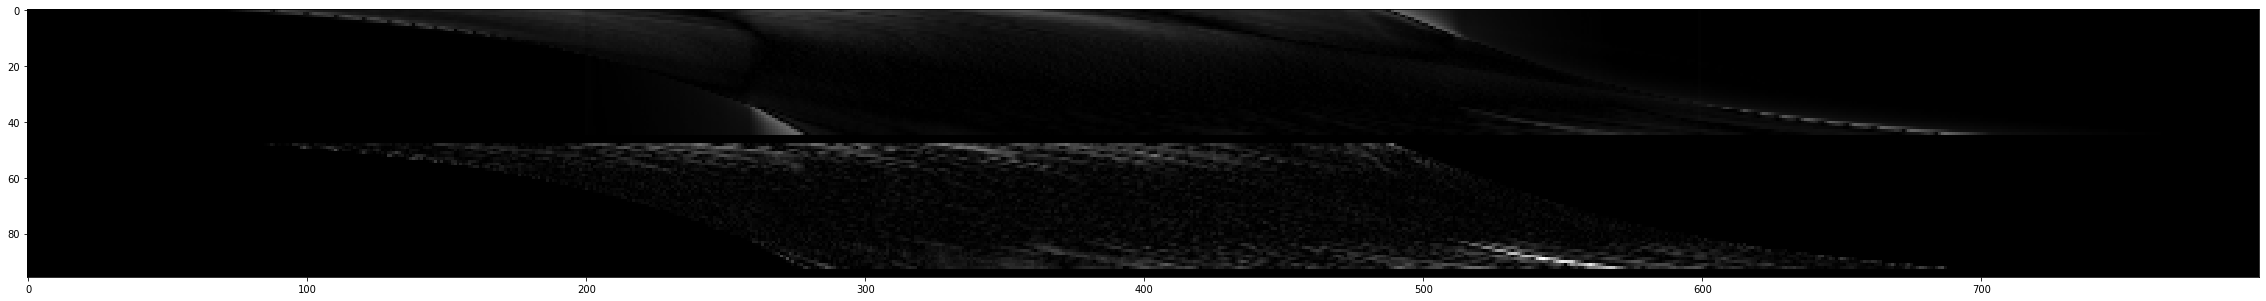

In [31]:
index = np.random.randint(0, len(result))
#print(index)
t1 = valx[index, :, :, 0]
t2 = result[index, :, :, 0]
t3 = valy[index, :, :, 0]

print( np.mean(np.abs(t1-t3)),  np.mean(np.abs(t1-t3))/np.mean(np.abs(t2-t3)), np.mean(np.abs(t2-t3)))

plt.figure(figsize=(40, 60))
#plt.imshow(np.concatenate([t1, t2, np.abs(t2-t1)*5, t4, np.abs(t4-t1)*5, t3, np.abs(t2-t3)*5, np.abs(t4-t3)*5], axis=-1).T, cmap='gray')
#plt.imshow(np.concatenate([t1, t2, np.abs(t3-t1)*10, np.abs(t2-t3)*100], axis=-1).T, cmap='gray')
plt.imshow(np.concatenate([np.abs(t3-t1)*10, np.abs(t2-t3)*10*np.mean(np.abs(t1-t3))/np.mean(np.abs(t2-t3))], axis=-1).T, cmap='gray')

In [ ]:
# For getting the full projection from the sinogram for lower resolution

# Reading the original central projections
valx_orig = np.zeros((36, 800, 300, 25), dtype=np.single) # These are the original noisy 25 projections
counter   = 0
for i in range(141, 177):
    x_noise_orig = loadmat('/media/dril/ubuntudata/DBT-NEW/gan-90-projections/projections/g_noi_'+str(i)+'.mat', verify_compressed_data_integrity=False)
    x_noise_orig = x_noise_orig['g_noi']
    print(i, x_noise_orig.shape)
    temp         = x_noise_orig[:, :, 10:-10]
    valx_orig[counter, :, :, :] = temp/5.0
    counter = counter+1

model  = load_model('/media/dril/ubuntudata/DBT-NEW/models/model-sinogram21.h5')
result = model.predict(valx, batch_size=16)

result = result[:, :, :45, 0]
valy   = valy[:, :, :45, 0]
valx   = valx[:, :, :45, 0]
valx   = valx[:, :, 10:-10]

#valx   = valx_orig                # Replace the central projections

print(valx.shape)

result_25_full = np.zeros((36, 800, 300, 25), dtype=np.single)
result_full    = np.zeros((36, 800, 300, 45), dtype=np.single)
ground_full    = np.zeros((36, 800, 300, 45), dtype=np.single)

valy_full   = []
totalcount  = 0

for i in range(36):
    #result_25_full[i, :, :, :] = valx[totalcount, :, :]     # Coming from sart
    for j in range(300):
        result_25_full[i, :, j, :] = valx[totalcount, :, :]     # Coming from sart
        result_full[i, :, j, :]    = result[totalcount, :, :]   # Prediction from the model, now replace the center 25 projections with original
        ground_full[i, :, j, :]    = valy[totalcount, :, :]     # No noise projections 
        totalcount = totalcount+1

# Replacing the central 25 projections
print('Replacing the central 25 projections')
result_full[:, :, :, 10:-10] = valx_orig[:, :, :, :]

print('Converted to projections from line sinograms')
print(result_full.shape, ground_full.shape)

# Write to .mat file
if(1):
    for i in range(0, 36):
        h1 = {}
        h1['prediction']     = result_full[i]*5.0
        savemat('/media/dril/ubuntudata/DBT-NEW/gan-90-projections/predictions/model-sinogram21/'+str(i+1)+'_prediction.mat', h1, do_compression=True)
        
        h1 = {}
        h1['prediction_25']  = valx_orig[i]
        savemat('/media/dril/ubuntudata/DBT-NEW/gan-90-projections/predictions/model-sinogram21/'+str(i+1)+'_input.mat',      h1, do_compression=True)
        
        h1 = {}
        h1['groundtruth']    = ground_full[i]
        savemat('/media/dril/ubuntudata/DBT-NEW/gan-90-projections/predictions/model-sinogram21/'+str(i+1)+'_groundtruth.mat', h1, do_compression=True)

print('Written to the disk')


In [11]:
i = 10
a = '/media/dril/ubuntudata/DBT-NEW/gan-90-projections/predictions/model-sinogram21/'+str(i+1)+'_prediction.mat'
a = loadmat(a)
a = a['prediction']
print(a.shape)

(800, 300, 45)


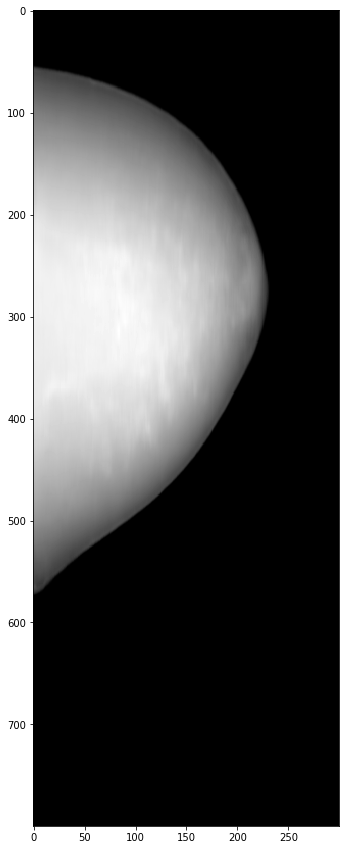

In [18]:
plt.figure(figsize=(30,15))
plt.imshow(a[:, :, 0]/5, cmap='gray')

In [ ]:
# For getting the full projection from the sinogram for higher resolution

# Reading the original central projections
valx_orig = np.zeros((36, 1600, 600, 25), dtype=np.single) # These are the original noisy 25 projections
counter   = 0
for i in range(141, 177):
    x_noise_orig = loadmat('/media/dril/ubuntudata/DBT-NEW/gan-90-projections-higher/projections/g_noi_'+str(i)+'.mat', verify_compressed_data_integrity=False)
    x_noise_orig = x_noise_orig['g_noi']
    print(i, x_noise_orig.shape)
    temp         = x_noise_orig[:, :, 10:-10]
    valx_orig[counter, :, :, :] = temp/5.0
    counter = counter+1

model  = load_model('/media/dril/ubuntudata/DBT-NEW/models/model-sinogram32-higher-dril.h5', compile=False)
result = model.predict(valx, batch_size=16)

result = result[:, :, :45, 0]
valy   = valy[:, :, :45, 0]
valx   = valx[:, :, :45, 0]
valx   = valx[:, :, 10:-10]

#valx   = valx_orig                # Replace the central projections

print(valx.shape)

result_25_full = np.zeros((36, 1600, 600, 25), dtype=np.single)
result_full    = np.zeros((36, 1600, 600, 45), dtype=np.single)
ground_full    = np.zeros((36, 1600, 600, 45), dtype=np.single)

valy_full   = []
totalcount  = 0

for i in range(36):
    #result_25_full[i, :, :, :] = valx[totalcount, :, :]     # Coming from sart
    for j in range(600):
        result_25_full[i, :, j, :] = valx[totalcount, :, :]     # Coming from sart
        result_full[i, :, j, :]    = result[totalcount, :, :]   # Prediction from the model, now replace the center 25 projections with original
        ground_full[i, :, j, :]    = valy[totalcount, :, :]     # No noise projections 
        totalcount = totalcount+1

# Replacing the central 25 projections
print('Replacing the central 25 projections')
result_full[:, :, :, 10:-10] = valx_orig[:, :, :, :]

print('Converted to projections from line sinograms')
print(result_full.shape, ground_full.shape)

# Write to .mat file
if(1):
    for i in range(0, 36):
        h1 = {}
        h1['prediction']     = result_full[i]*5.0
        savemat('/media/dril/ubuntudata/DBT-NEW/gan-90-projections-higher/predictions/model-sinogram32-higher-dril/'+str(i+1)+'_prediction.mat', h1, do_compression=True)
        
        h1 = {}
        h1['prediction_25']  = valx_orig[i]
        savemat('/media/dril/ubuntudata/DBT-NEW/gan-90-projections-higher/predictions/model-sinogram32-higher-dril/'+str(i+1)+'_input.mat',      h1, do_compression=True)
        
        h1 = {}
        h1['groundtruth']    = ground_full[i]
        savemat('/media/dril/ubuntudata/DBT-NEW/gan-90-projections-higher/predictions/model-sinogram32-higher-dril/'+str(i+1)+'_groundtruth.mat', h1, do_compression=True)

print('Written to the disk')

In [ ]:
# Make total Model from slices and save the up-sampled output

index   = 153#random.randint(0, 35)


#volx = loadmat('/home/dril/newrecon/ReconDBT/xfbp.mat', verify_compressed_data_integrity=False)
volx = loadmat('/media/dril/ubuntudata/DBT-NEW/recons-noise/fbp_'+str(index)+'_3_hann50.mat', verify_compressed_data_integrity=False)
voly = loadmat('/media/dril/ubuntudata/DBT-NEW/attenuation_values_cropped/'+str(index)+'.mat')  

volx = volx['xfbp']
voly = voly['head']
b    = voly

b    = volx#ndimage.zoom(volx, 0.50, order=1).astype(np.single)
voly = ndimage.zoom(voly, 0.125, order=1).astype(np.single)
volx = ndimage.zoom(volx, 0.250, order=1).astype(np.single)

testitx = []
testity = []

gap_slice = 1
for j in range(0, 36, gap_slice):
    x = volx[:, j:j+20, :]
    testitx.append(np.expand_dims(x, axis=-1))

for j in range(0, 36, gap_slice):
    y = voly[:, j:j+20, :]
    testity.append(np.expand_dims(y, axis=-1))

testitx = np.array(testitx)
testity = np.array(testity)

testitx  = np.pad(testitx, ((0,0), (2, 2), (2, 2), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))
testity  = np.pad(testity, ((0,0), (2, 2), (2, 2), (0, 0), (0, 0)), 'constant', constant_values = (0, 0))

result = model.predict(testitx, batch_size=4)

result  = result[:,  2:102, 2:22,  :, :]
testitx = testitx[:, 2:102, 2:22,  :, :]
testity = testity[:, 2:102, 2:22,  :, :]

#print(testitx.shape, testity.shape, result.shape)

# Joining the result to get the full volume from slice by slice results
final_result = []
for i in range(11):
    final_result.append(result[0, :, i, :, 0])
for i in range(0, len(result)):
    temp = result[i, :, 10, :, 0]
    final_result.append(result[i, :, 10, :, 0])
for i in range(11, 20):
    final_result.append(result[len(result)-1, :, i, :, 0])

final_result  = np.array(final_result)
final_result  = np.moveaxis(final_result, 0, 1)
print(final_result.shape)

# To save the upsampled low resolution deep learning model output
a       = loadmat('/media/dril/ubuntudata/DBT-NEW/attenuation_values_cropped/153.mat')
a       = a['head']
a       = ndimage.zoom(a, 0.5, order=1).astype(np.single)
result1 = ndimage.zoom(final_result, 4, order=1).astype(np.single)
h1         = {}
h1['deep'] = result1.astype('single')


diff_result = np.abs(result1-a)
diff_result[diff_result < 0.5]   = 0
diff_result[diff_result >= 0.5]  = 1
h2            = {}
h2['mask1']   = diff_result.astype('single')
print(np.count_nonzero(diff_result.flatten()))


diff_result = np.abs(result1-a)
diff_result[diff_result < 0.1]   = 0
diff_result[diff_result >= 0.5]  = 0
diff_result[diff_result >= 0.1]  = 1
h3            = {}
h3['mask2']   = diff_result.astype('single')
print(np.count_nonzero(diff_result.flatten()))


diff_result = np.abs(result1-a)
diff_result[diff_result >= 0.1]  = 0
diff_result[(diff_result > 0.05) & (diff_result < 0.1)]  = 1
diff_result[diff_result != 1]   = 0
h4            = {}
h4['mask3']   = diff_result.astype('single')
print(np.count_nonzero(diff_result.flatten()))

a[a!=0]             = 1
result1[result1!=0] = 1
totalmask           = h2['mask1']+h3['mask2']+h4['mask3']
totalmask[totalmask != 0] = 1

diff_result = np.abs(totalmask - result1)
diff_result[diff_result != 0]   = 1
h5            = {}
h5['mask4']   = diff_result.astype('single')
print(np.count_nonzero(diff_result.flatten()))


# Uncomment this code to write the output
savemat('/media/dril/ubuntudata/DBT-NEW/deeplearning_output/'+str(153)+'_3_hann50.mat',       h1, do_compression=True) # upsampled output
savemat('/media/dril/ubuntudata/DBT-NEW/deeplearning_output/'+str(153)+'_3_hann50_mask1.mat', h2, do_compression=True) # 0.5 <= error
savemat('/media/dril/ubuntudata/DBT-NEW/deeplearning_output/'+str(153)+'_3_hann50_mask2.mat', h3, do_compression=True) # 0.1 <= error <0.5
savemat('/media/dril/ubuntudata/DBT-NEW/deeplearning_output/'+str(153)+'_3_hann50_mask3.mat', h4, do_compression=True) # error < 0.1
savemat('/media/dril/ubuntudata/DBT-NEW/deeplearning_output/'+str(153)+'_3_hann50_mask4.mat', h5, do_compression=True) # rest mask